# Описание задачи

Команда дата-сайнтистов разработала новый алгоритм рекомендаций. Совместно с ними мы провели эксперимент о влиянии нового алгоритма на поведение пользователей. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован новый алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Прежде чем перейти к AB-тесту, проверим систему сплитирования.

## Подключение библиотек

In [1]:
#подключаемся к библиотекам
import pandas as pd
import pandahouse as ph
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from statsmodels.stats.power import TTestIndPower

# Проведение AA-теста

До проведения АВ-теста нам стоит убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале бы было провести бесконечное количество АА-тестов с извлечением кадый раз новой выборки из ГС, но на практике это практически невозможно, поэтому используем небольшой трюк.

Из имеющеся выборки мы будем многократно извлекать подвыборки без повторений из наших данных, проводить t-тест и в итоге посмотрим в скольких процентах случаях мы оклонили нулевую гипотезу и распределение p_value всех симуляций. При уровне значимости в 0,05 в 5% случаев мы получим стат значимые результаты - при условии уорректности системы сплитирования. 

Система сплитирования работала вхолостую неделю до проведения АВ-теста, с '2022-07-06' по '2022-07-12'. Номера групп 2 и 3 (exp_group).

## Функции для проведения теста

In [2]:
# функция расчёта p_value для двух выборок Т-тестом

def p_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    return p_val

In [3]:
# функция имитации множественного повтора АА-теста, 
    # передает лист p_value для каждого из них на проверку, 
    # показывает результат проверки, возвращает лист p_value
    # cnt - количество проведений
    
def aa_test(samp1, samp2, cnt = 10000):
    p_val_list = []
    
    for i in range(cnt):
        sub_samp1 = samp1.sample(500, replace=False).tolist()
        sub_samp2 = samp2.sample(500, replace=False).tolist()
        
        p_val_list.append(p_test(sub_samp1, sub_samp2))
    
    res = check_aa(p_val_list, cnt)
        
    return p_val_list, res

In [4]:
# функция проверки количества стат значимых результатов из общего числа

def check_aa(p_lst, number_of_repeat = 10000):
    
    cnt_p = [x for x in p_lst if x < 0.05]
    cnt_test_true = round(len(cnt_p) / number_of_repeat * 100, 4)
    
    return f'Количество стат значимых результатов из {number_of_repeat}: {cnt_test_true}% или {cnt_test_true/100 * number_of_repeat:.0f}'

In [5]:
# построение графика на два распределения

sns.set(rc={'figure.figsize':(14,8)})

def hists (samp1, samp2, txt1='', txt2='', title='', set_bins = 50):
    
    sns.histplot(samp1, color = 'green', alpha = 0.8, bins = set_bins, label = txt1)
    sns.histplot(samp2, color = 'orange', alpha = 0.6, bins = set_bins, label = txt2)
    plt.xlabel('')
    plt.legend(fontsize = 13)
    plt.title(title, fontsize = 15)
    plt.show()

## Предварительный анализ

Создадим датафрейм на основе предосталвенного csv.

In [6]:
df_aa = pd.read_csv('aa_test_sample.csv')

# Код извлечения данных из ClickHouse бд, в результате которого и был получен csv
# SELECT exp_group, 
#     user_id,
#     sum(action = 'like') as likes,
#     sum(action = 'view') as views,
#     likes/views as ctr
# FROM {db}.feed_actions 
# WHERE toDate(time) between '2022-07-06' and '2022-07-12'
#     and exp_group in (2,3)
# GROUP BY exp_group, user_id

df_aa.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


Сейчас датафрейм представлен в виде совокупной информации по обеим группам, поэтому мы разбиваем его на два относительно группы эксперимента.

In [7]:
df_aa_2, df_aa_3 = df_aa[df_aa.exp_group == 2], df_aa[df_aa.exp_group == 3]

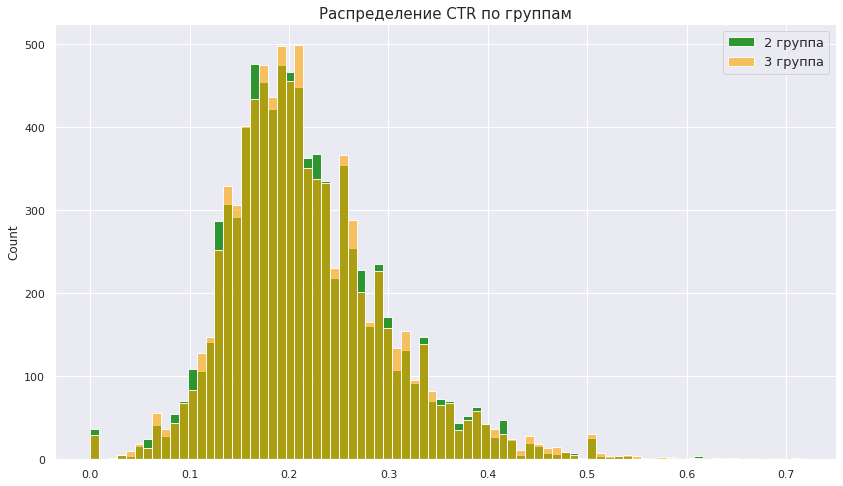

8_480 - Объём второй группы
8_569 - Объём третьей группы


In [8]:
hists(df_aa_2.ctr, df_aa_3.ctr, '2 группа', '3 группа', 'Распределение CTR по группам', 80)
print(f"{df_aa_2.ctr.count():_} - Объём второй группы\n{df_aa_3.ctr.count():_} - Объём третьей группы")

Визуально распределния не отличаются, проверим это симуляцией множественного проведения АА-теста.

Тк распределения имеют околонормальный вид (визуально) и объём обеих групп достаточно велик, то для проверки гипотезы подойдёт тест Стьюдента.

## AA-test

Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы и провести сравнение этих подвыборок t-testом.

Функция принимает на вход метрики двух сравниваемых групп и на выходе даёт список p_value каждой симуляции и текст вывода на его основе. Тело функции представлено во вкладке "Функции для проведения теста".

In [9]:
#считаем и собираем результаты АА-тестов
p_val_list, res = aa_test(df_aa_2.ctr, df_aa_3.ctr)

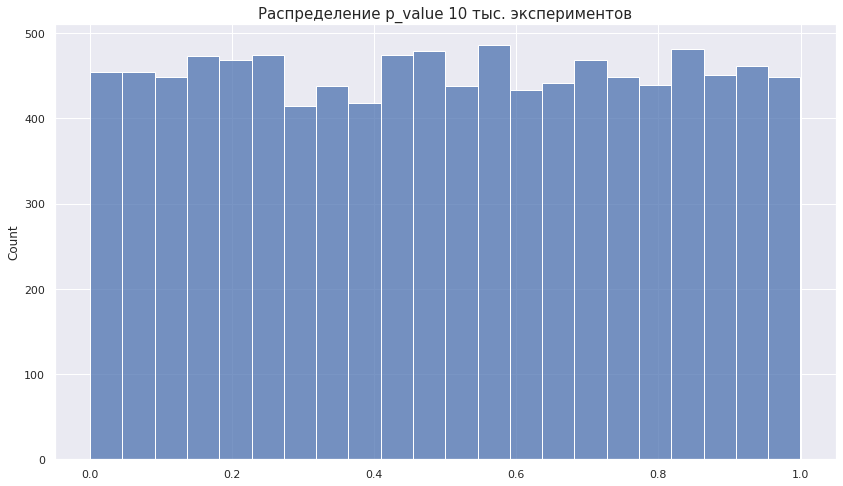

Количество стат значимых результатов из 10000: 5.05% или 505


In [10]:
sns.histplot(p_val_list)
plt.title('Распределение p_value 10 тыс. экспериментов', size = 15)

plt.show()
print(res)

## Вывод

P_value распределено равномерно, что соответствует ситуации истинности нулевой гипотезы - обе выборки принадлежат одному ГС. Это подтвержается и тем, что прокрас мы наблюдаем меньше, чем в 5% слуачев, такой уровень соотвествует уровню значимости альфа 0,05.

Вывод - **система сплитирования работает.**

# AB-тесты

Этим шагом мы проанализируем результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-07-13 по 2022-07-19 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Проведем несколько типов АВ-теста и сравним полученные результаты. На этом примере мы руками пощупаем каждый тест и оценим границы их проведения. 

В исследовании будем использовать t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования. Дополнительно посмотрим метод линеаризации ratio-метрик, разработанный командой Яндекса.

**Нулевая гипотеза** - выборки равны между собой, т.е. принадлежат одной генеральной совокупности ГС. **Альтернативная** - выборки отличаются, имеют стат значимые изменения и принадлежат разным ГС.

И начнём с того, что создадим датафрейм.

In [11]:
df_ab = pd.read_csv('ab_test_sample.csv')

# Код извлечения данных из ClickHouse бд, в результате которого и был получен csv
# SELECT exp_group, 
#     user_id,
#     sum(action = 'like') as likes,
#     sum(action = 'view') as views,
#     likes/views as ctr
# FROM {db}.feed_actions 
# WHERE toDate(time) between '2022-07-06' and '2022-07-12'
#     and exp_group in (2,3)
# GROUP BY exp_group, user_id

df_ab.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


И разобъем его на датафреймы эксперемнтальная группа и контрольная.

In [12]:
df_target, df_control = df_ab[df_ab.exp_group == 2], df_ab[df_ab.exp_group == 1]

## Функции для проведения тестов

In [13]:
# функция расчёта p_value для двух выборок Т-тестом

def t_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    
    print(f'Т-тест Стьюдента дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [14]:
# функция расчёта p_value для двух выборок Т-тестом

def t_test (samp1, samp2):
    p_val = stats.ttest_ind(samp1, samp2,
                equal_var=False)[1]
    
    print(f'Т-тест Стьюдента дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [15]:
# функция расчёта p_value двух выборок тестом Манна-Уитни
def t_mann (samp1, samp2):
    p_val = stats.mannwhitneyu(
        samp1, samp2,
        alternative = 'two-sided')[1]
    
    print(f'Тест Манна-Уитни дал p_value = {p_val}')
    print(f'Нулевая гипотеза отвергается, выборки принадлежат разным ГС' if p_val < 0.05 else f'Нулевая гипотеза принимается, выборки принадлежат одной ГС')
    
    return p_val

In [16]:
# функция сглаживания CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [17]:
# одно распределение

def hist_boost (samp, title='', set_bins = 50):
    
    samp_mean = samp.mean()
    sigma = 1.96 * samp.var() / len(samp)**0.5
    
    plt.axvline(x = 0) # визуальная проверка на включение в разницу нуля
    
    sns.histplot(samp, color = 'blue', alpha = 0.5, bins = set_bins)
    plt.title(title, fontsize = 15)
    plt.show()
    
    print(f'Дисперсия = {samp.var():.5f}, Среднее = {samp.mean():.5f}, sigma = {sigma:.5f}')
    
# функция для графика двух распределений hists() определена в части AA-теста
# hists (samp1, samp2, txt1='', txt2='', title='', set_bins = 50)

In [18]:
# функция Пуассоновского бутстрапа

def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

## Предварительный анализ и классический АВ-тест

Нулевая гипотеза - выборки равны между собой, т.е. принадлежат одной генеральной совокупности ГС. Альтернативная - выборки отличаются, имеют стат значимые изменения и принадлежат разным ГС.

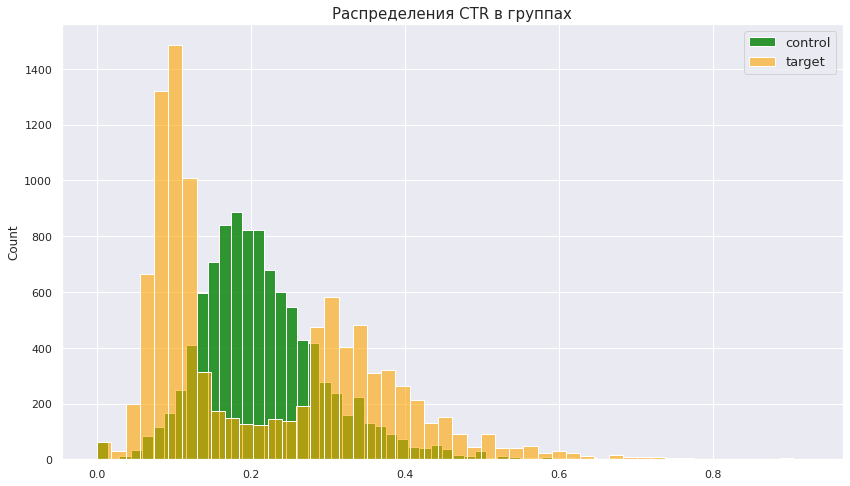

50_395 - Объём control группы
49_760 - Объём target группы
0.007 - Дисперсия control группы
0.021 - Дисперсия target группы

1.77% - минимально обнаруживаемый эффект с мощностью 1-b = 0.8 и уровнем значимости a=0.05 на заданных размерах выборок.


In [19]:
hists(df_control.ctr, df_target.ctr, 'control', 'target', 'Распределения CTR в группах')
print(f"{df_control.size:_} - Объём control группы\n{df_target.size:_} - Объём target группы")
print(f"{df_control.ctr.var():.3f} - Дисперсия control группы\n{df_target.ctr.var():.3f} - Дисперсия target группы")

# рассчитаем MDE
analysis = TTestIndPower()
print(f"\n{analysis.solve_power(power = 0.8, nobs1=df_control.size, ratio=df_target.size / df_control.size, alpha=0.05) * 100:.2f}% - минимально обнаруживаемый эффект" + \
        " с мощностью 1-b = 0.8 и уровнем значимости a=0.05 на заданных размерах выборок.")

Распределения одного размаха, но визуально очевидно расходятся. Контрольное распределние визуально похожее на нормальное, эксперементальное неоднородно и имеет бимодальный вид, и его дисперсия в 3 раза выше. Чтобы определить качество таких изменений необходимо провести тестирование.

Распределение целевой группы двухгорбое, т.е. не нормального вида, поэтому Т-тест не даст точные результаты. Подтвердим это.

In [20]:
p_val_tt = t_test(df_control.ctr, df_target.ctr)

Т-тест Стьюдента дал p_value = 0.4780623130874935
Нулевая гипотеза принимается, выборки принадлежат одной ГС


In [21]:
p_val_mann = t_mann(df_control.ctr, df_target.ctr)

Тест Манна-Уитни дал p_value = 6.0376484617779035e-56
Нулевая гипотеза отвергается, выборки принадлежат разным ГС


Тесты дали взаимоисключающие результаты, но как говорилось выше, t_тесту в данном случае мы верить не будем, тк он имеет явное ограничение на нормальность (в некоторых случаях околонормальность) исследуемых метрик.

Тест Манна Уитни использует ранжирование для поиска расхождений, поэтому он сохраняет чувствительность для разнотипных распределений. Его результаты в нашем случае надежны, и по ним принимается вывод об отвержении нулевой гипотезы. 

Но тест Манна-Уитни показывает только разницу в функциях распределения, поэтому может быть практически неинтерпретируем продуктово. Для этого отдельно рассмотрим изменения в разрезе среднего наших метрик.

In [22]:
print(f'Среднее контрольной группы: {df_control.ctr.mean():.3f}\nСреднее экспериментальной группы: {df_target.ctr.mean():.3f}')

Среднее контрольной группы: 0.216
Среднее экспериментальной группы: 0.214



CTR в результате эксперимента упал, т.к. среднее контрольной группы выше. Т.е. в целом изменения сказалаись негативно на продукте.

Закрепим наше исследование использованием других подходов к анализу эксепримента.

## Сглаженный CTR

Для повышения чувсвительности Т-теста метрику можно складить, приводя её вид ближе к академическому нормальному. Но в нашем случае разнотипные распределения, поэтому сглаженность CTR не принесет улучшений для т-теста. Проверим это.

In [23]:
global_ctr_control = df_control.likes.sum()/df_control.views.sum()
global_ctr_target = df_target.likes.sum()/df_target.views.sum()

In [24]:
df_control_ctr = df_control.copy()
df_control_ctr['smothed_ctr'] = df_control.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_control), axis=1)

In [25]:
df_target_ctr = df_target.copy()
df_target_ctr['smothed_ctr'] = df_target.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_target), axis=1)

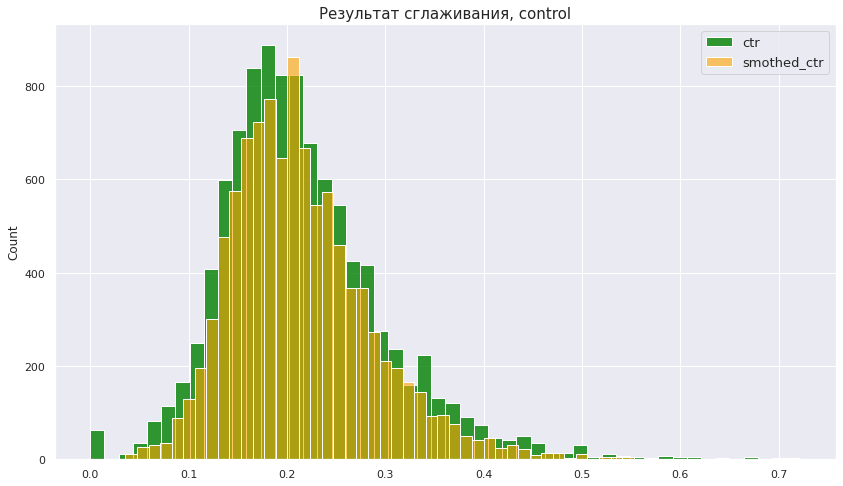

0.216 - Среднее ctr
0.214 - Среднее smothed_ctr


In [26]:
hists(df_control_ctr.ctr, df_control_ctr.smothed_ctr, 'ctr', 'smothed_ctr', 'Результат сглаживания, control')
print(f"{df_control_ctr.ctr.mean():.3f} - Среднее ctr\n{df_control_ctr.smothed_ctr.mean():.3f} - Среднее smothed_ctr")

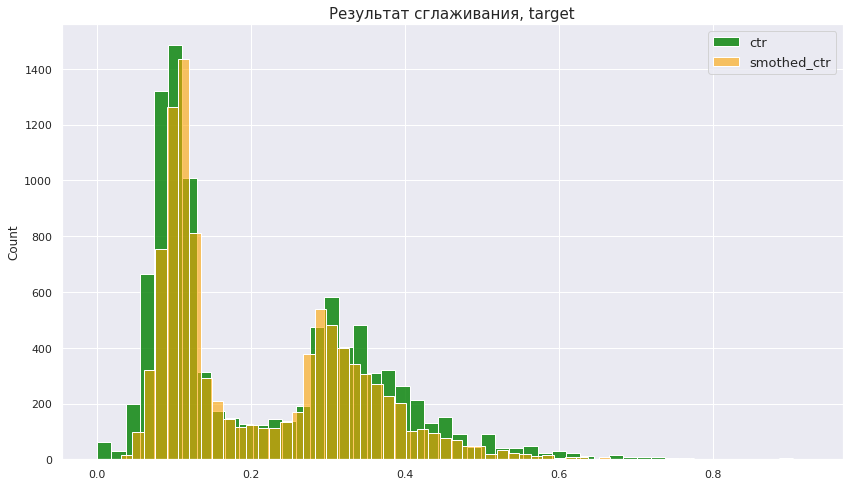

0.214 - Среднее ctr
0.211 - Среднее smothed_ctr


In [27]:
hists(df_target_ctr.ctr, df_target_ctr.smothed_ctr, 'ctr', 'smothed_ctr', 'Результат сглаживания, target')
print(f"{df_target_ctr.ctr.mean():.3f} - Среднее ctr\n{df_target_ctr.smothed_ctr.mean():.3f} - Среднее smothed_ctr")

Сглаживание замтно повлияло на контрольную группу, причесав его от выбросов и облегчив хвосты. На экспериментольной группы изменения не столь примечательны, тк сглаживание не может поменять тип распределния, т.е. мы все еще не моем использовать успешно t-тест.

In [28]:
p_val_tt_ctr = t_test(df_control_ctr.ctr, df_target_ctr.ctr)

Т-тест Стьюдента дал p_value = 0.4780623130874935
Нулевая гипотеза принимается, выборки принадлежат одной ГС


Расчёт вывел точно такое же значение p_value, как и до сглаживания. Сглаженное CTR ожидаемо не повлияло на тестирование.

Стоит также отметить, что сглаживание не 100% будет отражать реальную картину, поэтому использовать его следует с осторожностью.

## Пуассоновский бутстрап

Бутстрап не чувствителен к виду распределения и позволяет считать глобальные метрики. Благодаря этому мы можем провести расчёты не только поюзерного CTR, но и глобального CTR. К тому же Пуассоновский бутстрап сильно упрощает вычисления, т.к. не создаёт подвыборки из группы, а генерирует, сколько раз каждое из значений попало бы в подвыборку.

Сымитировав проведения множества экспериментов, далее мы будем работать с распределниями глобальных CTR в контрольной и экспериментальной группах, построенными из выборочных CTR'ов. И среднее такого распределения будет стремится к реальному CTR.

In [29]:
gl_ctr_control, gl_ctr_target = poisson_bootstrap(df_control.likes.to_numpy(), df_control.views.to_numpy(), df_target.likes.to_numpy(), df_target.views.to_numpy())

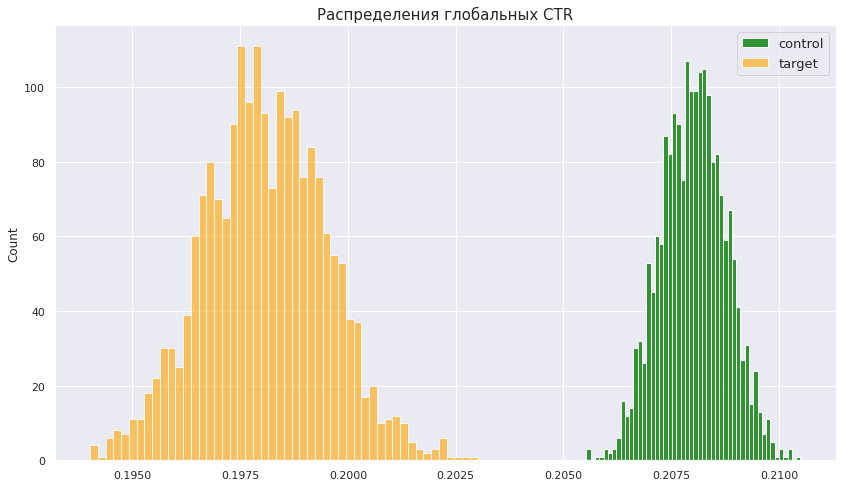

0.208 - Среднее control группы
0.198 - Среднее target группы
Глобальное CTR control группы: 0.208
Глобальное CTR target группы: 0.198


In [30]:
hists(gl_ctr_control, gl_ctr_target, 'control', 'target', 'Распределения глобальных CTR')

print(f"{gl_ctr_control.mean():.3f} - Среднее control группы\n{gl_ctr_target.mean():.3f} - Среднее target группы")
print(f'Глобальное CTR control группы: {df_control.likes.sum() / df_control.views.sum():.3f}')
print(f"Глобальное CTR target группы: {df_target.likes.sum() / df_target.views.sum():.3f}")

Наблюдаем, что средние boot-распределений совпадают с глобальными значениями CTR в исходных группах.

Визуально очевидна деградация метрики в экспериментальной группе. И сохранение более высокой дисперсии в экспериментальной группе.

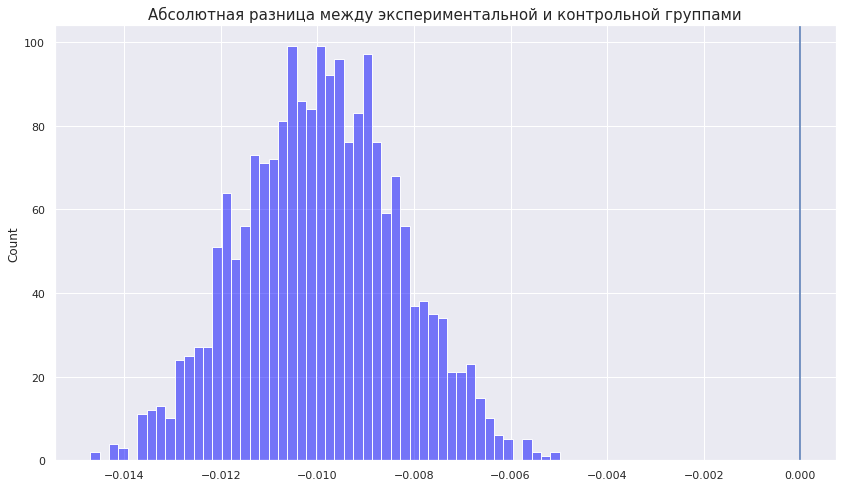

Дисперсия = 0.00000, Среднее = -0.00993, sigma = 0.00000


In [31]:
hist_boost(gl_ctr_target - gl_ctr_control, 'Абсолютная разница между экспериментальной и контрольной группами')

Распределение разницы не включает ноль и содержит только отрицательные значение. Следовательно нулевая гипотеза отвергается - выборки не принадлежат одной ГС, изменения есть. Но изменения негативные, глобальный CTRстат значимо понизился.

Дисперсия разницы равна нулю, отчего доверительный интервал выродился в среднее разницы вилечин. Что показывает однозначность описанных выше результатов.

## Бакетное преобразование

Тест с бакетным преобразование также даёт возможность анализировать глобальные метрики, т.к. на основе заданной выборки создает N репрезентативных выборок, которые имитируют N экспериментов.

Разобъём выборки на 50 бакетов.

In [32]:
df_backet = pd.read_csv('backets_sample.csv')

# Код извлечения данных из ClickHouse бд, в результате которого и был получен csv
# SELECT 
#     exp_group, 
#     bucket,
#     sum(likes)/sum(views) as bucket_ctr
# FROM (
#     SELECT exp_group,
#         xxHash64(user_id)%50 as bucket,
#         user_id,
#         sum(action = 'like') as likes,
#         sum(action = 'view') as views,
#         likes/views as ctr
#     FROM {db}.feed_actions
#     WHERE toDate(time) between '2022-07-13' and '2022-07-19'
#         and exp_group in (0,1,2,3)
#     GROUP BY exp_group, bucket, user_id
# )
# GROUP BY exp_group, bucket

df_backet.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [33]:
df_b_target, df_b_control = df_backet[df_backet.exp_group == 2], df_backet[df_backet.exp_group == 1]

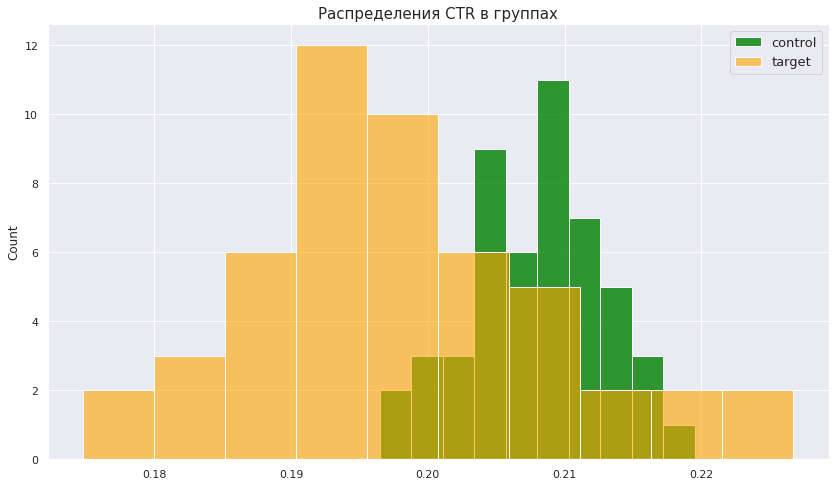

0.208 - Среднее control группы
0.198 - Среднее target группы
Глобальное CTR control группы: 0.208
Глобальное CTR target группы: 0.198


In [34]:
hists(df_b_control.bucket_ctr, df_b_target.bucket_ctr, 'control', 'target', 'Распределения CTR в группах', set_bins = 10)

print(f"{df_b_control.bucket_ctr.mean():.3f} - Среднее control группы\n{df_b_target.bucket_ctr.mean():.3f} - Среднее target группы")
print(f'Глобальное CTR control группы: {df_control.likes.sum() / df_control.views.sum():.3f}')
print(f"Глобальное CTR target группы: {df_target.likes.sum() / df_target.views.sum():.3f}")

Наблюдаем, что средние бакетных распределений совпадают с глобальными значениями CTR в исходных группах.

Мы получили нормальное распределение, которое стремится к реальному значению. Благодаря этому мы можем равноценно использовать и Т-тест, и тест Манна-Уитни. Дисперсия всё так же выше у эксперементальной группы и визуально видно, что её пик находится левее, чем пик метрики контрольной группы.

In [35]:
p_val_tt = t_test(df_b_control.bucket_ctr, df_b_target.bucket_ctr)

Т-тест Стьюдента дал p_value = 3.4455951649945907e-07
Нулевая гипотеза отвергается, выборки принадлежат разным ГС


In [36]:
p_val_mann = t_mann(df_b_control.bucket_ctr, df_b_target.bucket_ctr)

Тест Манна-Уитни дал p_value = 2.859963936492646e-07
Нулевая гипотеза отвергается, выборки принадлежат разным ГС


In [37]:
print(f'Среднее контрольной группы: {df_b_control.bucket_ctr.mean():.3f}\nСреднее экспериментальной группы: {df_b_target.bucket_ctr.mean():.3f}')

Среднее контрольной группы: 0.208
Среднее экспериментальной группы: 0.198


Оба теста показали те же результаты. Отвергаем Н0, фиксируем отрицательные изменения метрики CTR.

## Линеаризация ratio-метрик от Яндекса

Идея метода: вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR.

Расчёт метрики:
* Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
* Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
* После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

In [38]:
# Считаем глобальный CTR в контрольной группе
global_ctr = sum(df_ab[df_ab.exp_group == 1].likes) / sum(df_ab[df_ab.exp_group == 1].views)

In [39]:
#добавляем для каждой группы свою метрику линеаризированных лайков относительно  глобального CTR соотвествующей контрольной группы
df_ab['linearized_likes'] = df_ab.likes - global_ctr * df_ab.views

In [40]:
# Разбиваем основной датафрейм на дополнительных относительно их номера группы в экспериментах 
df_lc_control, df_lc_target = df_ab[df_ab.exp_group == 1], df_ab[df_ab.exp_group == 2]

Посмотрим, как визуально изменилась метрика вовлеченности пользователя. CTR нормированная величина, поэтому умножим её на 100 для наглядности.

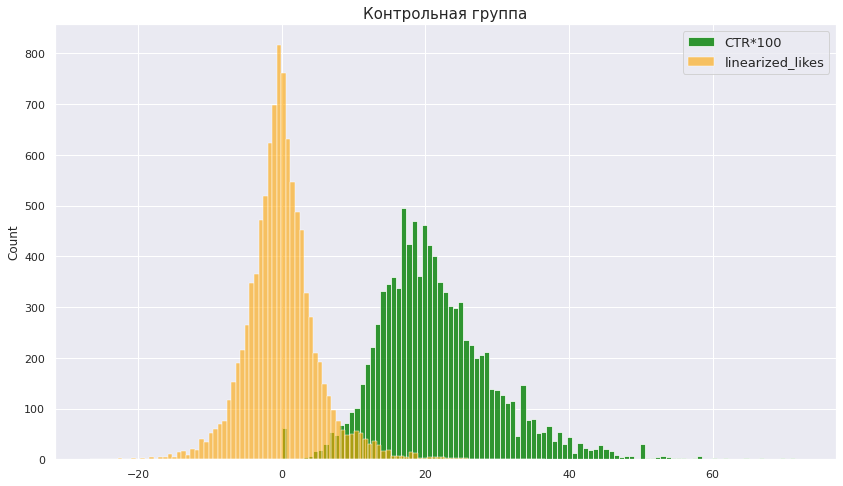

Контрольная группа:
7.083 - Дисперсия CTR*100
24.176 - Дисперсия linearized_likes


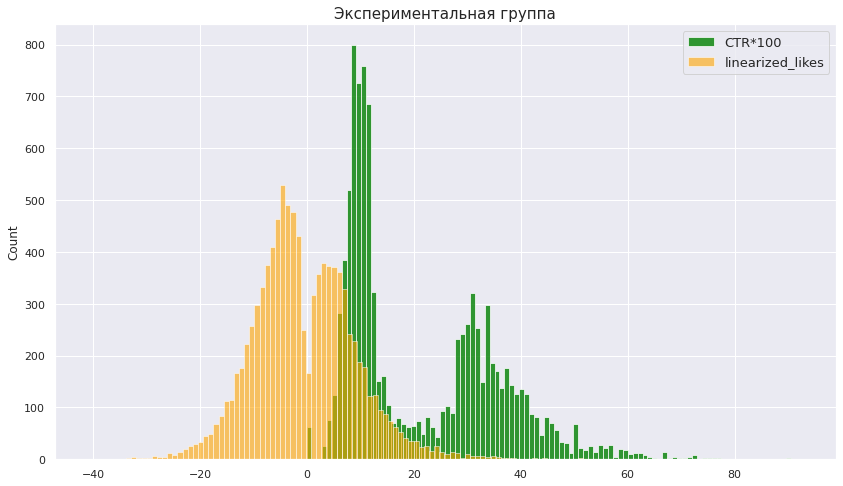

Экспериментальная группа:
207.879 - Дисперсия CTR*100
91.521 - Дисперсия linearized_likes


In [41]:
hists(df_lc_control.ctr*100, df_lc_control.linearized_likes, 'CTR*100', 'linearized_likes', 'Контрольная группа', set_bins = 100)
print(f"Контрольная группа:\n{df_lc_control.ctr.var()*1000:.3f} - Дисперсия CTR*100\n{df_lc_control.linearized_likes.var():.3f} - Дисперсия linearized_likes")

hists(df_lc_target.ctr*100, df_lc_target.linearized_likes, 'CTR*100', 'linearized_likes', 'Экспериментальная группа', set_bins = 100)
print(f"Экспериментальная группа:\n{df_lc_target.ctr.var()*10000:.3f} - Дисперсия CTR*100\n{df_lc_target.linearized_likes.var():.3f} - Дисперсия linearized_likes")

Благодаря линеаризации метрика визуально приобрела вид нормального распределения, уменьшила дисперсию. Таким образом мы повысили чувствительность и можем использовать Т-тест, доверяя его результатам.

Проведём тест для старой и новой метрики и посмотрим, как изменятся его результаты.

In [42]:
p_valt = t_test(df_lc_control.linearized_likes, df_lc_target.linearized_likes)  # Новая метрика

Т-тест Стьюдента дал p_value = 9.439432187037712e-10
Нулевая гипотеза отвергается, выборки принадлежат разным ГС


In [43]:
p_val_tt = t_test(df_lc_control.ctr, df_lc_target.ctr)  # Старая метрика 

Т-тест Стьюдента дал p_value = 0.4780623130874935
Нулевая гипотеза принимается, выборки принадлежат одной ГС


Старая метрика имеет ненормальное распределение, поэтому сырой тест даёт ненадежные результаты. После преобразования метрика приобрела визуально нормальный вид и теперь Т-тест даёт надежные результаты.

# Выводы

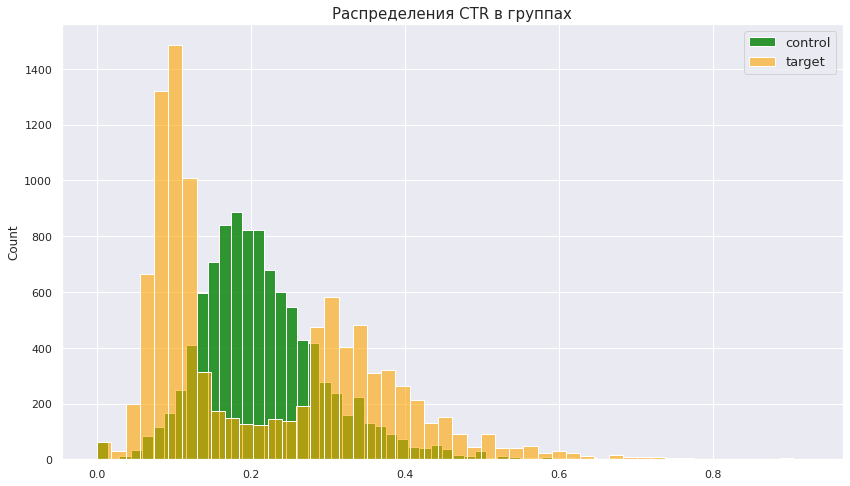

In [44]:
hists(df_control.ctr, df_target.ctr, 'control', 'target', 'Распределения CTR в группах')

Если смотреть на картину в целом, то результаты нововведния стат значимы и негативно влияют на продукт.

Если смотреть на результат глубже, то можно сказать, что эксперимент был не бессмысленным. Пользователи сгруппировались в два пика - и для одного из них тест достиг цели, CTR возросла. Результаты можно отправить на доработку, если выявить, что объединяет пользователей в обоих пиках. Попробывать сохранить улучшения для правого пика и доработать алгоритм для пользователей левого пика.

Но при этом на всех пользователей в целом выкатывать не стоит, тк глобального метрика стат значимо упала.